# CygnusX

In [2]:
import aplpy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -8.508e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.649e+02 [aplpy.core]


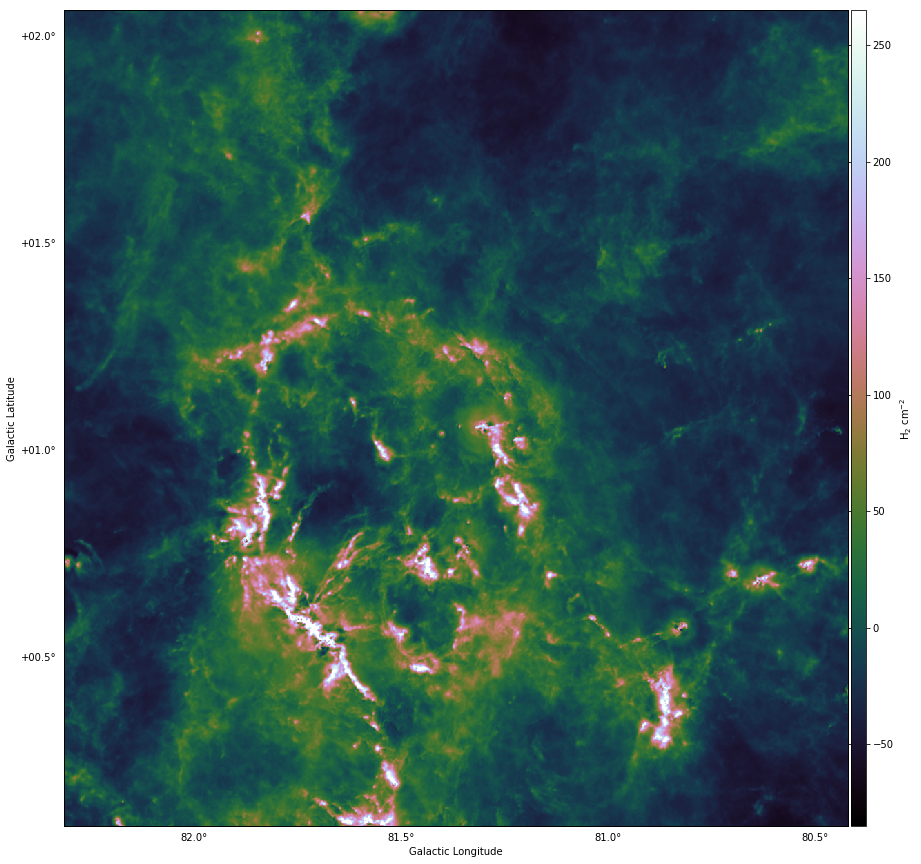

In [3]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_alt.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [4]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy.io import fits
from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [5]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [30]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.95)
imt = imzm *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size at 500 micron
#beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[3]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k/spec_beamn, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.1]*25
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=False, apodize= 0.98, arrdim = np.array([1500,1500]))

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(wav_k, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1an[2,:], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef = np.polyfit(np.log(wav_k[7:21]),np.log(S1an[2,7:21]),deg=1)
yfit = np.exp(coef[1])*wav_k**coef[0]

coef2 = np.polyfit(np.log(wav_k[14:21]),np.log(S1an[1,14:21]),deg=1)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print "Power law = ", coef[0],coef2[0]

f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

showbok(f)

[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
1500 1500
Power law =  -3.2201332222884926 -2.7499012562957676


In [31]:
#Plot Beam power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_beamn, legend='Fourier')
f.diamond(Bwav_k, BS1an, legend='Wavelet',color='black',line_width=5)
showbok(f)

[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
wav_k.shape[0]= 25


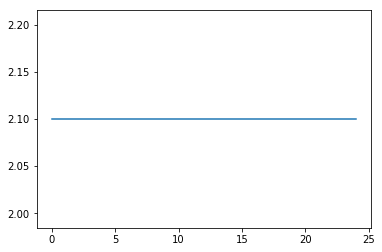

In [32]:
print q
print 'wav_k.shape[0]=',wav_k.shape[0]

x = range(25)
plot(x,np.array(q).reshape(25))

In [33]:
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wt.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S11a.npy',S11a)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wav_k.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S1a.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_q.npy',q)

INFO: Auto-setting vmin to -9.758e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.502e+02 [aplpy.core]
INFO: Auto-setting vmin to -1.134e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.834e+02 [aplpy.core]


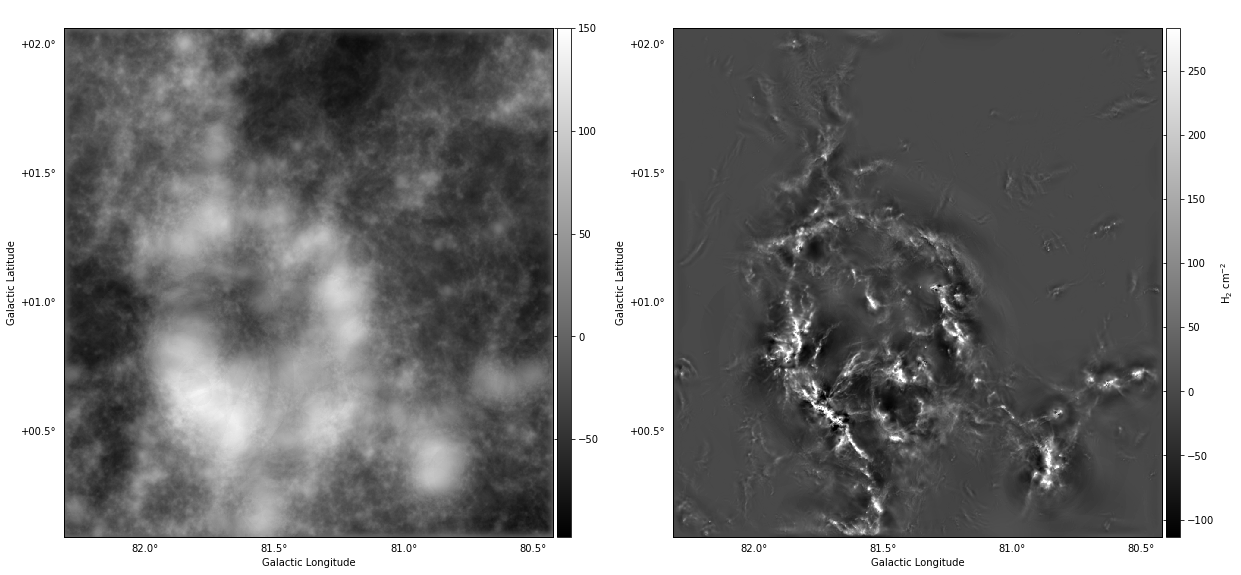

In [34]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0) + np.mean(im)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0) + np.mean(im)

fits.writeto('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

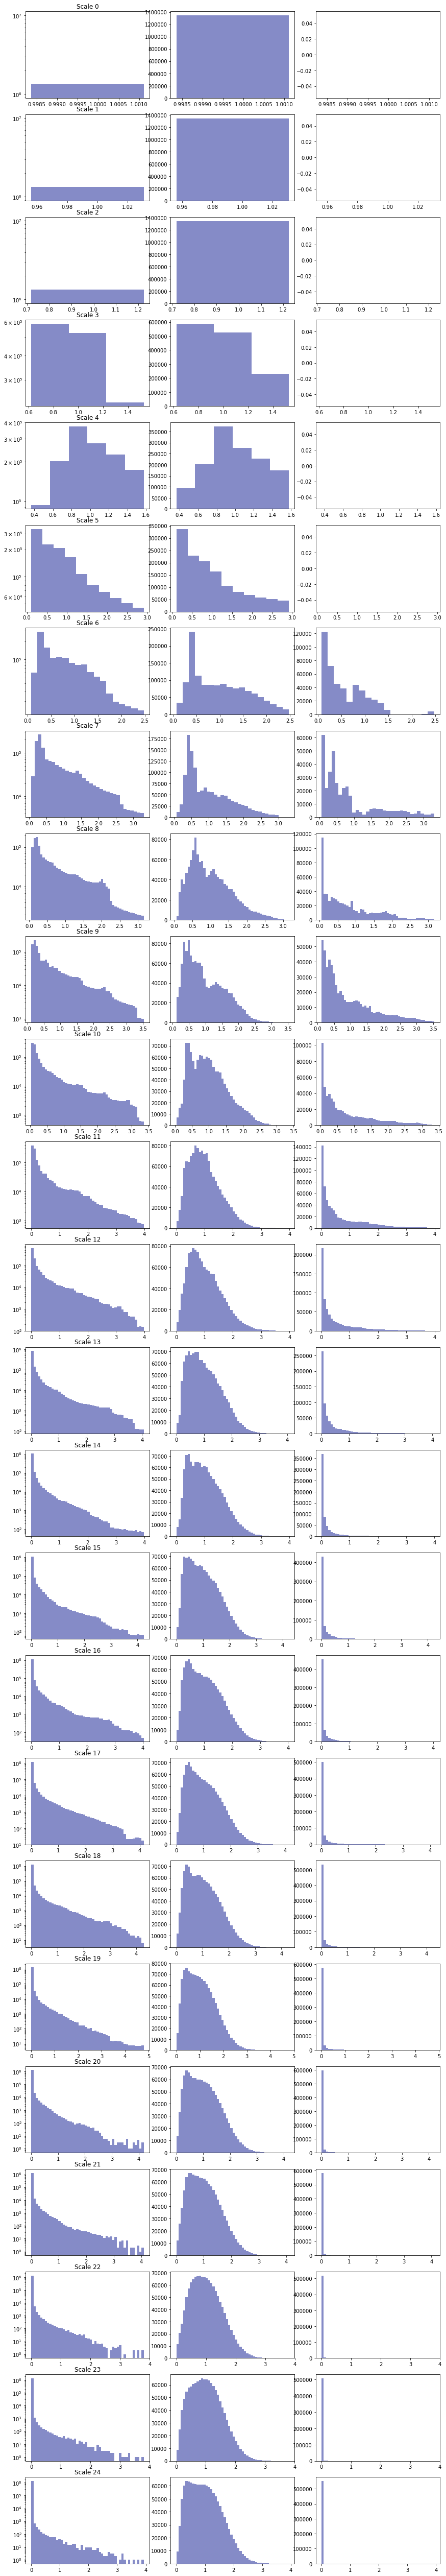

In [35]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    
    if np.mean(S11a[M+i,:,:]) !=0:
        wc = (S11a[M+i,:,:])/np.mean(S11a[M+i,:,:])
    else:
        wc = np.zeros((im.shape[0],im.shape[1]))
    wo = (S11a[i,:,:])/np.mean(S11a[i,:,:])
    #wg = (S11a[2*M+i,0:100 & 700:,:])/np.mean(S11a[2*M+i,:,:])
    #wg = (S11a[2*M+i,100:700,:])/np.mean(S11a[2*M+i,:,:])
    wg = (S11a[2*M+i,:,:])/np.mean(S11a[2*M+i,:,:])
    
    #Number of independent points
    npix = np.int((im.shape[0] * wav_k[i]*reso)**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=50
    
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3].set_title('Scale '+np.str(i))
    axs[i*3].set_yscale('log')
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')

In [36]:
from gaussfit import *

(array([4.19423100e+04, 3.52040779e-01, 7.99914270e-02, 5.89494967e+04,
       9.26164188e-01, 5.60976530e-01]), 1)


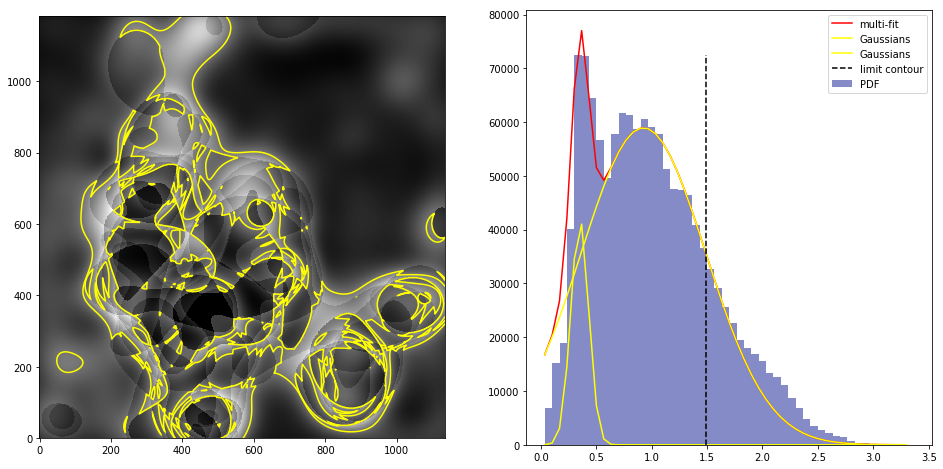

In [38]:
scale = 10

plt.figure(figsize=(16,8))

wg = (S11a[2*M+scale,:,:])/np.mean(S11a[2*M+scale,:,:])
histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)

plt.subplot(121)
plt.imshow(wg,origin='below',cmap='gray')
plt.subplot(122)
plt.bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7',label='PDF')

#Gaussian fit
params = []
params.append([5e4, 0.6, 0.1])
params.append([3e4, 1.50, 0.3])
#params.append([2.6e4, 1.25, 1.5])

fit = gaussfit(edges[:-1], histo_g, params)

print fit

nbpar=len(fit[0])/3
newpar=fit[0].reshape((nbpar,3))
plot(edges[:-1], multi_gaussians(edges[:-1], fit[0]),color='red',linewidth=1.5,label='multi-fit')
for j in range(nbpar):
    plt.plot(edges[:-1], gaussian(edges[:-1], newpar[j,0], newpar[j,1], newpar[j,2]),color='yellow',linewidth=1.5,label='Gaussians')
    
#Draw contours associated with the fits
p = 1
plt.subplot(121)
plt.contour(wg,[newpar[p,1]+newpar[p,2]],colors='yellow')
plt.subplot(122)
plt.plot([newpar[p,1]+newpar[p,2],newpar[p,1]+newpar[p,2]],[0,np.max(histo_g)],color='black',linestyle='dashed',linewidth=1.5,label='limit contour')
plt.legend()